# 掛載資料集並解壓縮

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import zipfile

zip_path = '/content/drive/MyDrive/master/113-2/DL_Final/All Data/dataset_all.zip'
#zip_path = '/content/dataset_all.zip'
extract_dir = '/content/yolo_dataset'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# Import

In [ ]:
!pip install torch torchvision scikit-learn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 97.1 MB/s eta 0:00:00


In [3]:
import os
import torch
import torchvision
import numpy as np
import torch.nn as nn
from PIL import Image
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet50
from sklearn.metrics import precision_score, recall_score, f1_score

# 將yolo label轉成multilabel


In [4]:
def build_multilabel_dict(label_dir, num_classes):
    multilabels = {}
    for file in os.listdir(label_dir):
        if not file.endswith(".txt"):
            continue
        file_path = os.path.join(label_dir, file)
        image_id = file.replace(".txt", "")
        label_vector = np.zeros(num_classes, dtype=np.float32)
        with open(file_path, "r") as f:
            for line in f:
                cls_id = int(line.strip().split()[0])
                label_vector[cls_id] = 1.0
        multilabels[image_id] = label_vector
    return multilabels


# Parameters Setting

In [5]:
base_path = "/content/yolo_dataset/dataset_all"
batch_size = 32
num_classes = 7
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4
criterion = nn.BCELoss()
use_pretrain = False

# Prepare and Resize Dataset

In [6]:
class MultiLabelImageDataset(Dataset):
    def __init__(self, image_dir, label_dict, transform=None, image_ext=".jpg"):
        self.image_dir = image_dir
        self.label_dict = label_dict
        self.image_ids = list(label_dict.keys())
        self.transform = transform
        self.image_ext = image_ext

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_path = os.path.join(self.image_dir, img_id + self.image_ext)
        image = Image.open(img_path).convert("RGB")
        label = self.label_dict[img_id]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float32)


In [7]:
# Resize 成 ResNet 輸入格式 + normalization
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

#build multi label from yolo
train_labels = build_multilabel_dict(os.path.join(base_path, "train", "labels"), num_classes)
val_labels = build_multilabel_dict(os.path.join(base_path, "val", "labels"), num_classes)
test_labels = build_multilabel_dict(os.path.join(base_path, "test", "labels"), num_classes)

train_dataset = MultiLabelImageDataset(os.path.join(base_path, "train", "images"), train_labels, transform)
val_dataset = MultiLabelImageDataset(os.path.join(base_path, "val", "images"), val_labels, transform)
test_dataset = MultiLabelImageDataset(os.path.join(base_path, "test", "images"), test_labels, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Model Definition

## Resnet

In [8]:
def get_resnet_model(num_classes):
    model = resnet50(pretrained=use_pretrain)
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 512),
        nn.BatchNorm1d(512),
        nn.LeakyReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, num_classes)  # ❗️不加 Sigmoid
    )
    return model

# Set Training Env

In [9]:
resnet_model = get_resnet_model(num_classes).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(resnet_model.parameters(), lr=learning_rate)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


# Def train/eval process

In [10]:
def train_one_epoch(model, dataloader, criterion, optimizer):
    model.train()
    total_loss = 0
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(dataloader)

def validate(model, dataloader, threshold=0.6):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for imgs, labels in dataloader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels.numpy())

    y_pred = np.vstack(all_preds)
    y_true = np.vstack(all_labels)
    return y_pred, y_true


## Train

In [11]:
save_path = '/content/drive/MyDrive/master/113-2/DL_Final/Resnet50/best_model.pt'
best_f1 = -1
for epoch in range(30):
    train_loss = train_one_epoch(resnet_model, train_loader, criterion, optimizer)
    val_preds, val_labels = validate(resnet_model, val_loader)

    # 計算 micro F1
    val_preds_bin = (val_preds > 0.5).astype(int)
    f1 = f1_score(val_labels, val_preds_bin, average='micro', zero_division=0)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, F1: {f1:.4f}")

    # 儲存最佳模型
    if f1 > best_f1:
        best_f1 = f1
        torch.save(resnet_model.state_dict(), save_path)
        print(f"✅ Best model saved (F1: {best_f1:.4f})")

Epoch 1, Train Loss: 0.5340, F1: 0.1640
✅ Best model saved (F1: 0.1640)
Epoch 2, Train Loss: 0.3984, F1: 0.2940
✅ Best model saved (F1: 0.2940)
Epoch 3, Train Loss: 0.3394, F1: 0.2211
Epoch 4, Train Loss: 0.3127, F1: 0.3918
✅ Best model saved (F1: 0.3918)
Epoch 5, Train Loss: 0.2774, F1: 0.4735
✅ Best model saved (F1: 0.4735)
Epoch 6, Train Loss: 0.2498, F1: 0.5106
✅ Best model saved (F1: 0.5106)
Epoch 7, Train Loss: 0.2264, F1: 0.5401
✅ Best model saved (F1: 0.5401)
Epoch 8, Train Loss: 0.1991, F1: 0.3431
Epoch 9, Train Loss: 0.1918, F1: 0.4586
Epoch 10, Train Loss: 0.1620, F1: 0.6349
✅ Best model saved (F1: 0.6349)
Epoch 11, Train Loss: 0.1530, F1: 0.4481
Epoch 12, Train Loss: 0.1286, F1: 0.6753
✅ Best model saved (F1: 0.6753)
Epoch 13, Train Loss: 0.1246, F1: 0.5451
Epoch 14, Train Loss: 0.0921, F1: 0.6259
Epoch 15, Train Loss: 0.0873, F1: 0.7218
✅ Best model saved (F1: 0.7218)
Epoch 16, Train Loss: 0.0806, F1: 0.7063
Epoch 17, Train Loss: 0.0665, F1: 0.7828
✅ Best model saved (F1: 

# Load old model

## Eval

In [ ]:
def report_per_label_metrics(y_true, y_pred, threshold=0.7):
    y_pred_bin = (y_pred > threshold).astype(int)
    print("Precision:", precision_score(y_true, y_pred_bin, average=None))
    print("Recall:", recall_score(y_true, y_pred_bin, average=None))
    print("F1:", f1_score(y_true, y_pred_bin, average=None))


In [ ]:
test_preds, test_labels = validate(resnet_model, test_loader,threshold=0.5)
report_per_label_metrics(test_labels, test_preds)

cuda
Precision: [0.88679245 0.86666667 1.         0.70588235 0.96       0.20833333
 0.85333333]
Recall: [0.58024691 0.28888889 0.3902439  0.6        0.70588235 1.
 0.77108434]
F1: [0.70149254 0.43333333 0.56140351 0.64864865 0.81355932 0.34482759
 0.81012658]


In [ ]:
threshold = 0.5
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = resnet_model(images)
        probs = torch.sigmoid(outputs)
        preds = (probs > threshold).float().cpu()

        all_preds.append(preds)
        all_labels.append(labels)

# === 5. 合併所有 batch 的預測與標籤 ===
y_true = torch.cat(all_labels).numpy()
y_pred = torch.cat(all_preds).numpy()

# === 6. sklearn 精確統計 ===
precision = precision_score(y_true, y_pred, average='micro', zero_division=0)
recall = recall_score(y_true, y_pred, average='micro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='micro', zero_division=0)

# === 7. 自訂 Per-label Accuracy ===
correct_per_class = (y_true * y_pred).sum(axis=0)
total_per_class = y_true.sum(axis=0)
per_label_accuracy = np.mean(correct_per_class / (total_per_class + 1e-8))

# === 8. 顯示結果 ===
print(f"🎯 Per-label Accuracy: {per_label_accuracy:.4f}")
print(f"📊 Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

🎯 Per-label Accuracy: 0.6195
📊 Precision: 0.6624, Recall: 0.6047, F1-score: 0.6322


In [15]:
y_true, y_pred = validate(resnet_model, test_loader)
def evaluate_multilabel(y_true, y_pred, threshold=0.6, class_names=None):
    # 轉為 0/1 預測
    y_pred_bin = (y_pred > threshold).astype(int)

    # === 🎯 Micro ===
    micro_precision = precision_score(y_true, y_pred_bin, average='micro', zero_division=0)
    micro_recall = recall_score(y_true, y_pred_bin, average='micro', zero_division=0)
    micro_f1 = f1_score(y_true, y_pred_bin, average='micro', zero_division=0)

    # === 🎯 Macro ===
    macro_precision = precision_score(y_true, y_pred_bin, average='macro', zero_division=0)
    macro_recall = recall_score(y_true, y_pred_bin, average='macro', zero_division=0)
    macro_f1 = f1_score(y_true, y_pred_bin, average='macro', zero_division=0)

    # === 🎯 Per-label Accuracy（每一類的準確率）===
    correct = (y_true == y_pred_bin).astype(np.float32)
    per_label_acc = correct.mean(axis=0)  # 每個類別
    mean_label_acc = per_label_acc.mean() # 平均

    # === 📊 印出結果 ===
    print("🔹 Micro")
    print(f"  - Precision : {micro_precision:.4f}")
    print(f"  - Recall    : {micro_recall:.4f}")
    print(f"  - F1-score  : {micro_f1:.4f}")

    print("\n🔸 Macro")
    print(f"  - Precision : {macro_precision:.4f}")
    print(f"  - Recall    : {macro_recall:.4f}")
    print(f"  - F1-score  : {macro_f1:.4f}")

    print("\n🎯 Per-label Accuracy")
    if class_names:
        for i, name in enumerate(class_names):
            print(f"  - {name:10s} : {per_label_acc[i]:.4f}")
    else:
        for i, acc in enumerate(per_label_acc):
            print(f"  - Class {i}   : {acc:.4f}")
    print(f"  → Mean Accuracy: {mean_label_acc:.4f}")
class_names= ['chiikawa', 'hachiware', 'kurimanju', 'momonga', 'rakko', 'shisa', 'usagi']
evaluate_multilabel(y_true,y_pred, class_names=class_names)


🔹 Micro
  - Precision : 0.7006
  - Recall    : 0.8225
  - F1-score  : 0.7567

🔸 Macro
  - Precision : 0.6663
  - Recall    : 0.8379
  - F1-score  : 0.7079

🎯 Per-label Accuracy
  - chiikawa   : 0.9062
  - hachiware  : 0.8924
  - kurimanju  : 0.9132
  - momonga    : 0.9132
  - rakko      : 0.9618
  - shisa      : 0.9514
  - usagi      : 0.9236
  → Mean Accuracy: 0.9231


🔹 Class: chiikawa
Confusion Matrix:
[[ 47  34]
 [  6 201]]


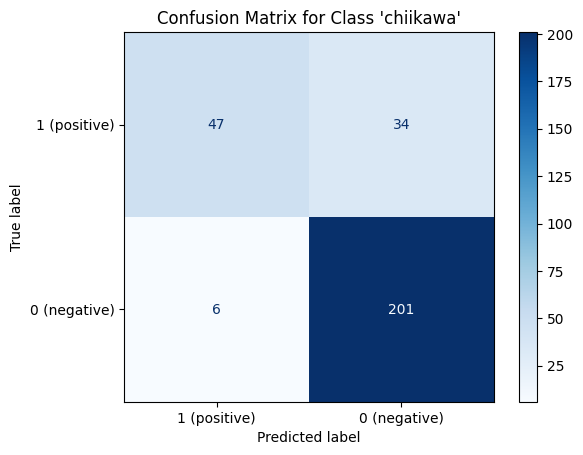

🔹 Class: hachiware
Confusion Matrix:
[[ 13  32]
 [  2 241]]


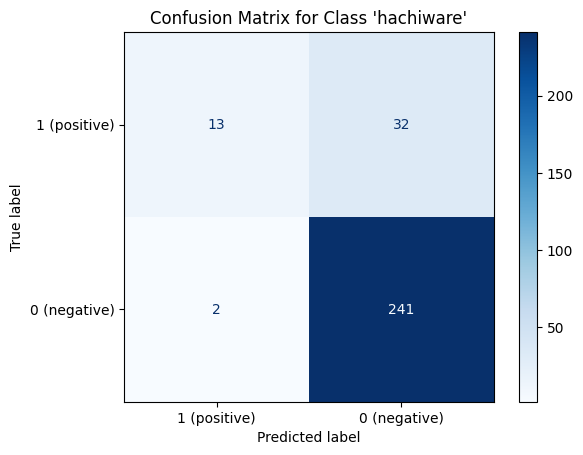

🔹 Class: kurimanju
Confusion Matrix:
[[ 16  25]
 [  0 247]]


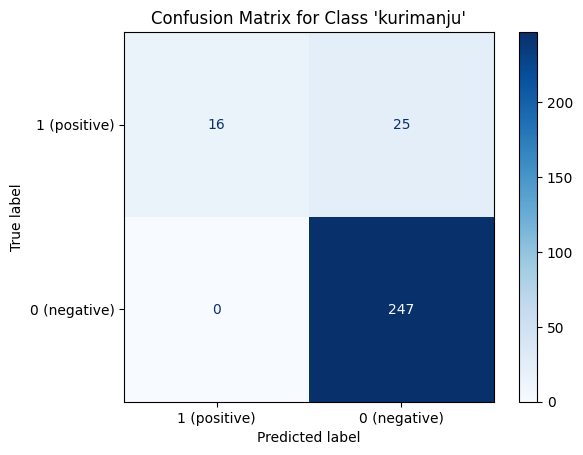

🔹 Class: momonga
Confusion Matrix:
[[ 24  16]
 [ 10 238]]


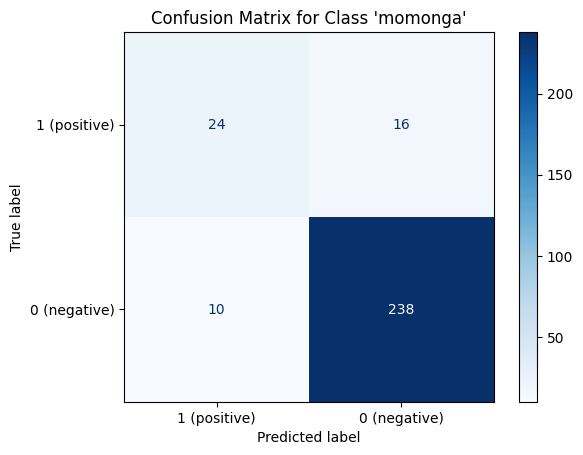

🔹 Class: rakko
Confusion Matrix:
[[ 24  10]
 [  1 253]]


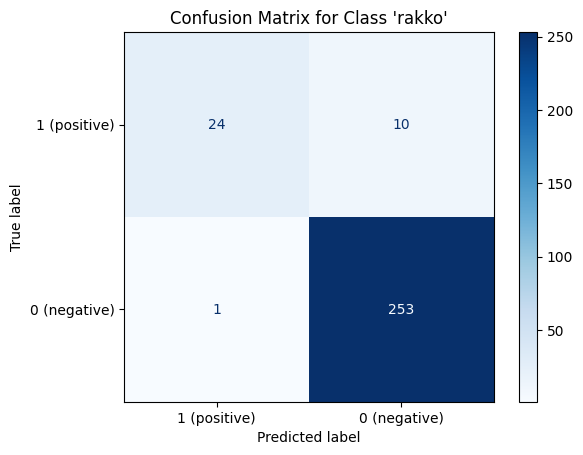

🔹 Class: shisa
Confusion Matrix:
[[ 20   0]
 [ 76 192]]


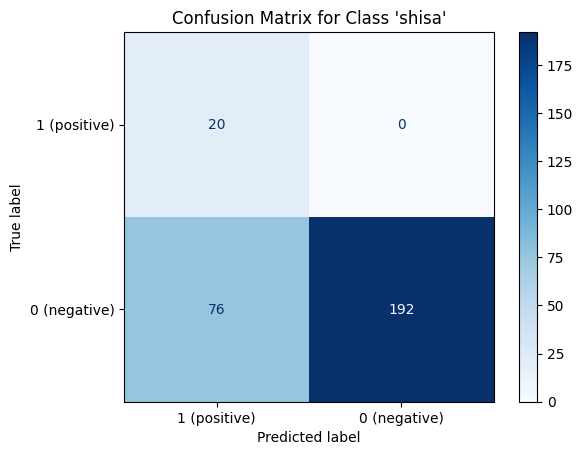

🔹 Class: usagi
Confusion Matrix:
[[ 64  19]
 [ 11 194]]


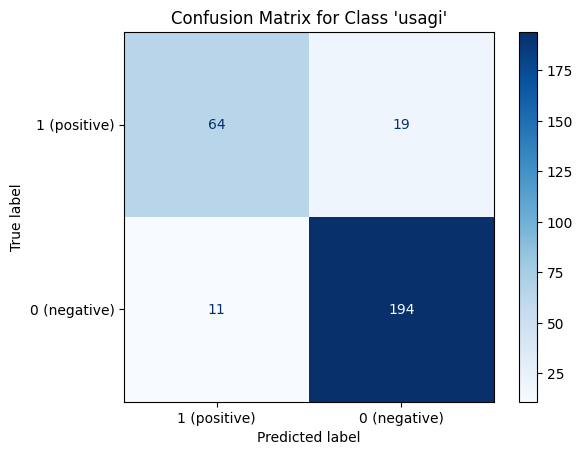

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_names= ['chiikawa', 'hachiware', 'kurimanju', 'momonga', 'rakko', 'shisa', 'usagi']
def plot_per_class_confusion(y_true, y_pred, class_names):
    num_classes = y_true.shape[1]
    for c in range(num_classes):
        y_true_c = y_true[:, c]
        y_pred_c = y_pred[:, c]

        cm = confusion_matrix(y_true_c, y_pred_c, labels=[1, 0])  # 保持順序: 1 (positive), 0 (negative)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['1 (positive)', '0 (negative)'])

        print(f"🔹 Class: {class_names[c]}")
        print(f"Confusion Matrix:\n{cm}")
        disp.plot(cmap="Blues")
        plt.title(f"Confusion Matrix for Class '{class_names[c]}'")
        plt.show()
plot_per_class_confusion(y_true, y_pred, class_names)

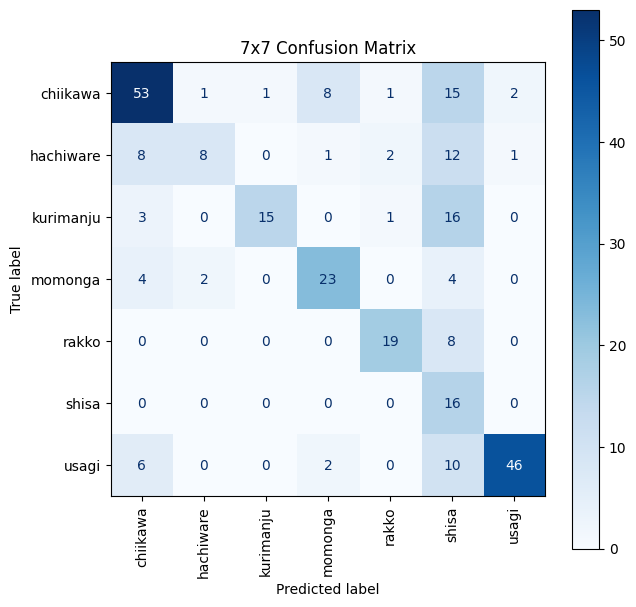

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

num_classes = 7  # 改為你的類別數
labels = ['chiikawa', 'hachiware', 'kurimanju', 'momonga', 'rakko', 'shisa', 'usagi']  # 類別名稱

def get_first_positive_label(arr):
    return np.argmax(arr)

y_true_single = [get_first_positive_label(row) for row in y_true]
y_pred_single = [get_first_positive_label(row) for row in y_pred]

# === 混淆矩陣 ===
cm = confusion_matrix(y_true_single, y_pred_single, labels=list(range(num_classes)))


# 繪圖
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(7, 7))
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation='vertical')
plt.title("7x7 Confusion Matrix")
plt.show()